In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchdiffeq import odeint

from data_collector import Omie
from neural_ode import (ODEfunc, Decoder, LatentODE, RecurrentNN, RunningAverageMeter, 
                        get_random_batch, get_norm_batch, 
                        log_normal_pdf, normal_kl, plot_y_y_pred, plot_prediction_true_scale)

# Data Wrangling

In [3]:
# uncomment this to obtain day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)

In [4]:
df = pd.read_csv("day_ahead_market.csv", parse_dates=["date"], 
                  date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d"))

df = df[["date", "hour", "spain"]].rename(columns={"spain": "price"})

# remove time change price
df = df[df["hour"] != 25]
# set hour as zero based
df["hour"] = df["hour"] - 1

df["datetime"] = pd.to_datetime(df["date"]) + (df["hour"]).astype('timedelta64[h]')
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)

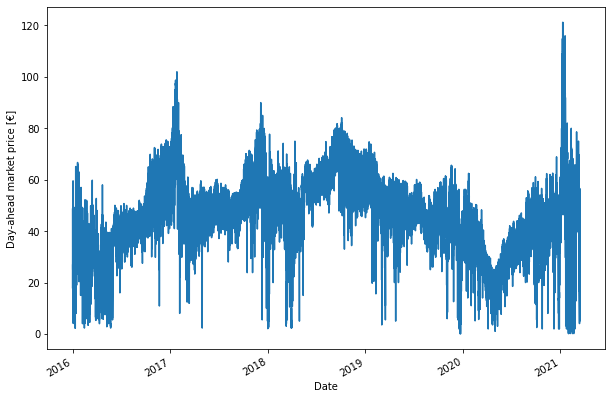

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
df[["price"]].plot(ax=ax, legend=False)
ax.set_xlabel("Date")
ax.set_ylabel("Day-ahead market price [€]")
plt.show()

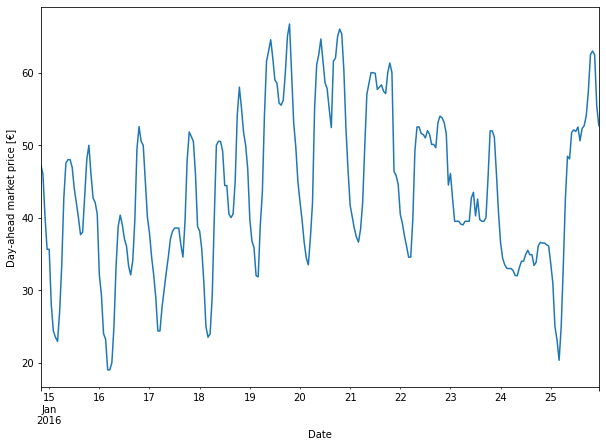

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
df[["price"]].loc["2016-01-14 20:00:00":"2016-01-25"].plot(ax=ax, legend=False)
ax.set_xlabel("Date")
ax.set_ylabel("Day-ahead market price [€]")
plt.show()

# NeuralODE - LatentODE framework

In [7]:
# For the sample augmentation, the mean and std must be computed in each iteration to avoid leakage
df_train_latent = df[df["date"] >= "2020-02-01"]
y_true = df_train_latent["price"]

## Simple NeuralODE

## LatentODE

In [8]:
# configure neural architecture
obs_dim = 1 # One-dimensional timeseries
latent_dim = 20 # Dimension of the latent space
rnn_hidden = 25 # Dimension of the hidden layer in the recurrentNN encoder 
nbatch = 1 # Number of samples in each minibatch
ode_hidden = 20 # Dimension of the hidden layer in the latent neural ODE
dec_hidden = 20 # Dimenson of the hidden layer in the NN decoder
noise_std = 0.5 # 

lr = 1e-3 # learning rate
epochs = 800 # number of epochs
trajectory_time_base = 24 # number of timesteps that enter into the encoder and the neural ODE must integrate
time_step = 6
s = 0

In [9]:
# define architecture
rnn = RecurrentNN(obs_dim=obs_dim, latent_dim=latent_dim, nhidden=rnn_hidden, nbatch=nbatch)
latent_func = LatentODE(latent_dim=latent_dim, nhidden=ode_hidden)
dec = Decoder(latent_dim=latent_dim, obs_dim=obs_dim, nhidden=dec_hidden)

params = (list(rnn.parameters()) + list(latent_func.parameters()) + list(dec.parameters()))

optimizer = torch.optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()

Running iteration 0 ... 
Iteration 0: 0001 | total loss -51.828743


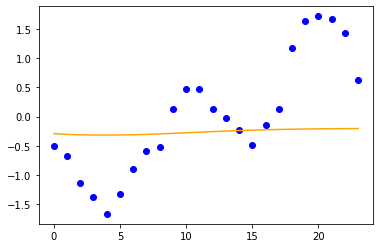

Iteration 0: 0800 | total loss -14.837115 | Time: 1.29 mins


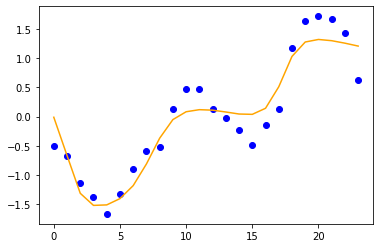

Prediction


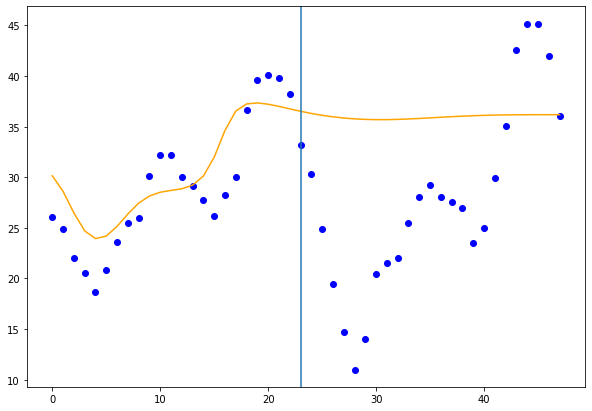

Running iteration 1 ... 
Running iteration 2 ... 
Iteration 2: 0001 | total loss -28.619833


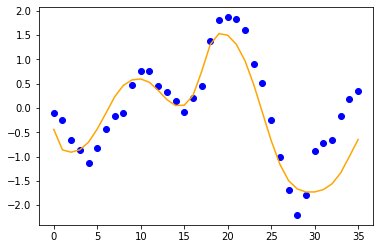

Iteration 2: 0800 | total loss -15.082713 | Time: 2.71 mins


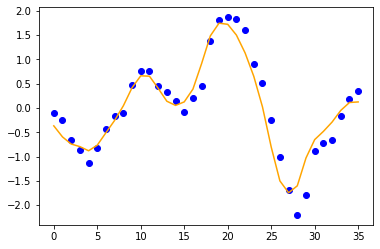

Prediction


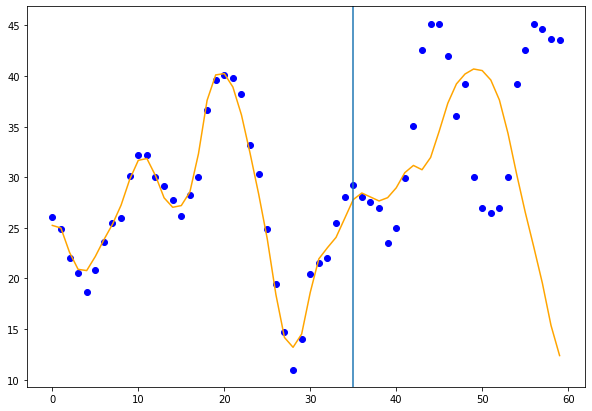

Running iteration 3 ... 
Running iteration 4 ... 
Iteration 4: 0001 | total loss -45.567215


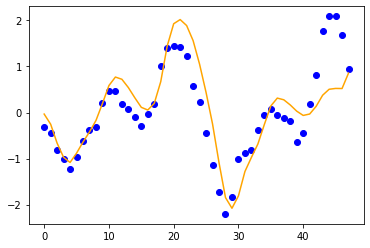

Iteration 4: 0800 | total loss -18.884049 | Time: 3.67 mins


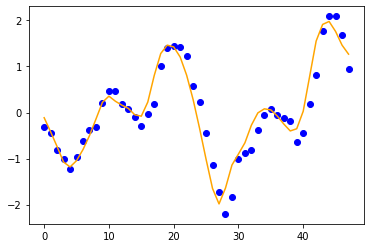

Prediction


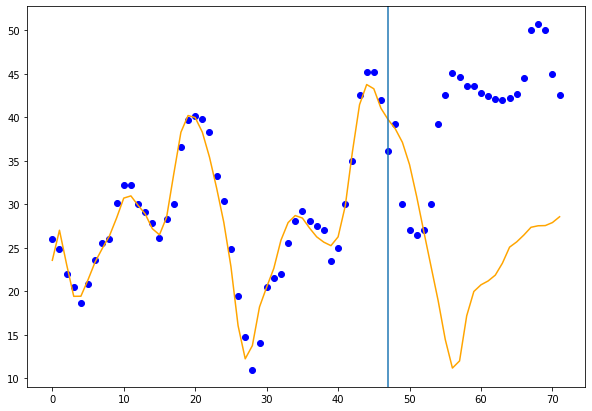

Running iteration 5 ... 
Running iteration 6 ... 
Iteration 6: 0001 | total loss -107.537201


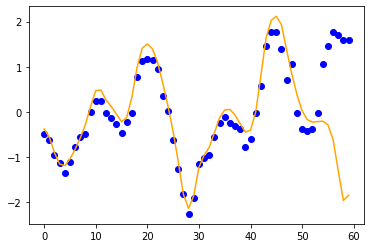

Iteration 6: 0800 | total loss -21.994049 | Time: 4.82 mins


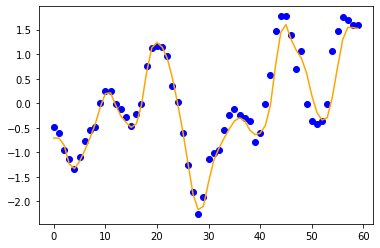

Prediction


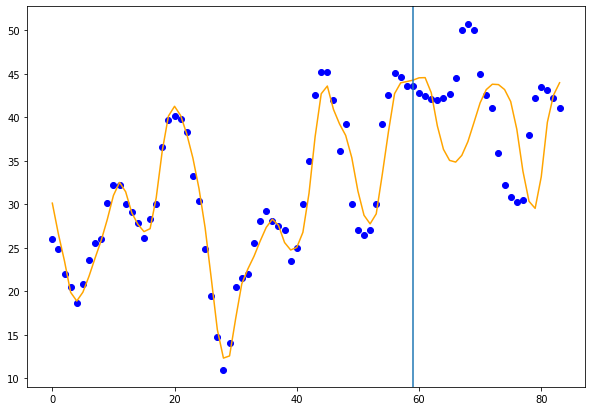

Running iteration 7 ... 
Running iteration 8 ... 
Iteration 8: 0001 | total loss -25.587868


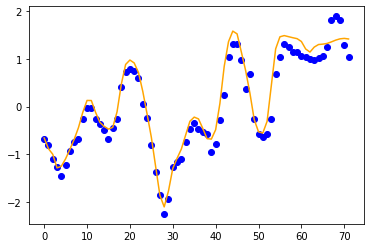

Iteration 8: 0800 | total loss -22.685940 | Time: 6.09 mins


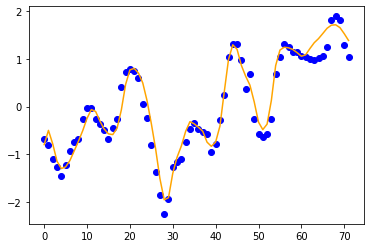

Prediction


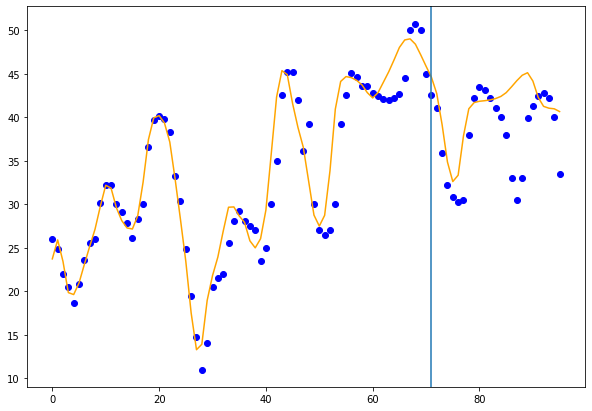

Running iteration 9 ... 
Running iteration 10 ... 
Iteration 10: 0001 | total loss -26.007467


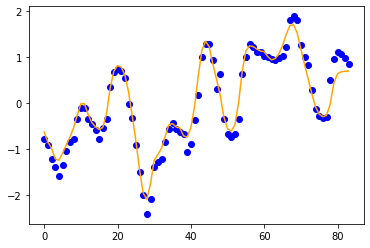

Iteration 10: 0800 | total loss -26.441244 | Time: 6.60 mins


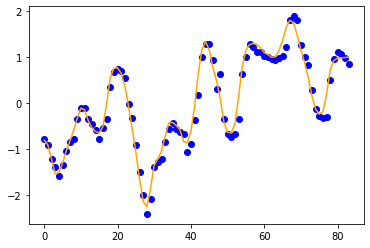

Prediction


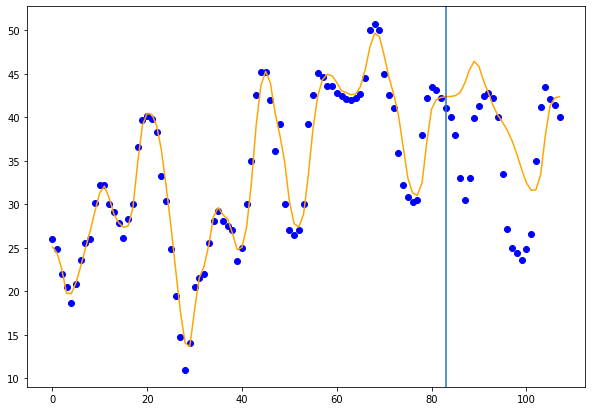

Running iteration 11 ... 
Running iteration 12 ... 
Iteration 12: 0001 | total loss -30.356550


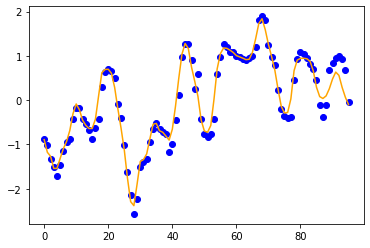

Iteration 12: 0800 | total loss -30.298247 | Time: 7.60 mins


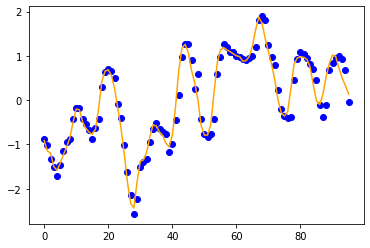

Prediction


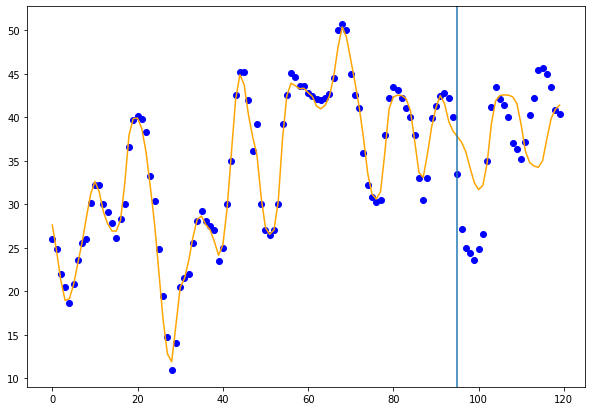

Running iteration 13 ... 
Running iteration 14 ... 
Iteration 14: 0001 | total loss -31.610445


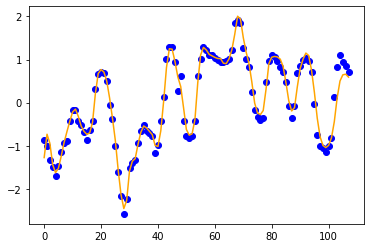

Iteration 14: 0800 | total loss -34.762010 | Time: 10.45 mins


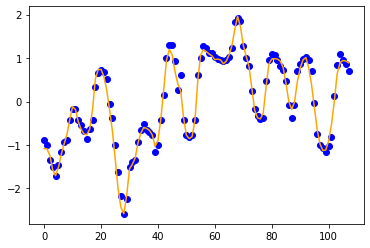

Prediction


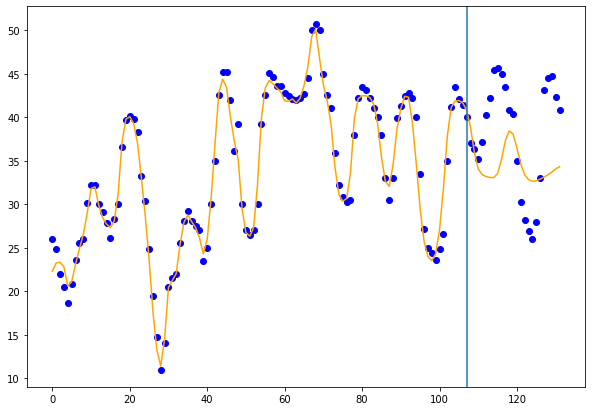

Running iteration 15 ... 
Running iteration 16 ... 
Iteration 16: 0001 | total loss -37.451931


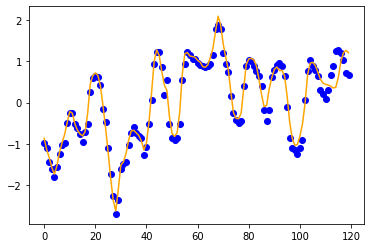

Iteration 16: 0800 | total loss -39.920696 | Time: 13.75 mins


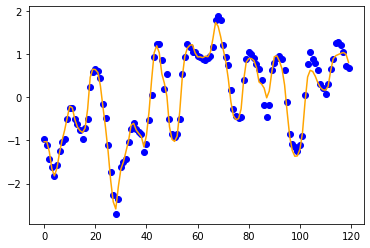

Prediction


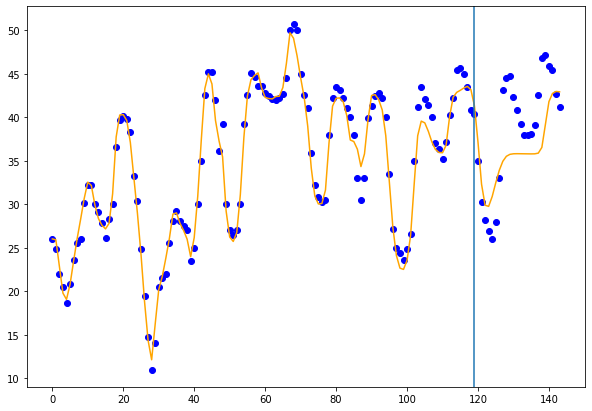

Running iteration 17 ... 
Running iteration 18 ... 
Iteration 18: 0001 | total loss -42.718761


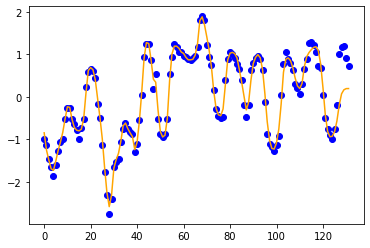

Iteration 18: 0800 | total loss -42.172233 | Time: 11.28 mins


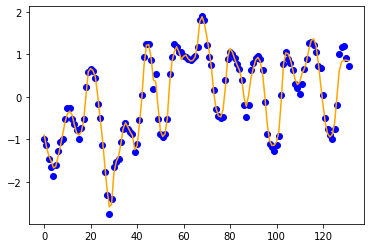

Prediction


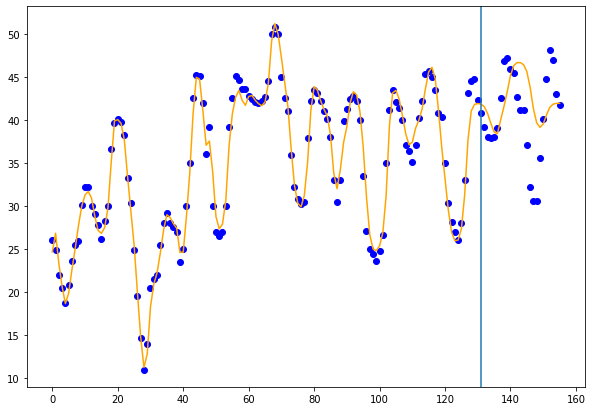

Running iteration 19 ... 
Running iteration 20 ... 
Iteration 20: 0001 | total loss -44.573807


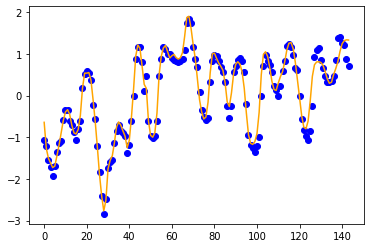

Iteration 20: 0800 | total loss -52.380907 | Time: 12.48 mins


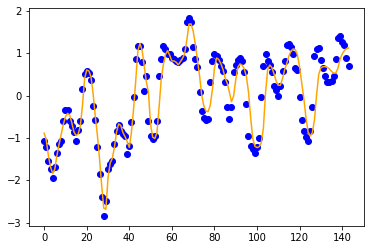

Prediction


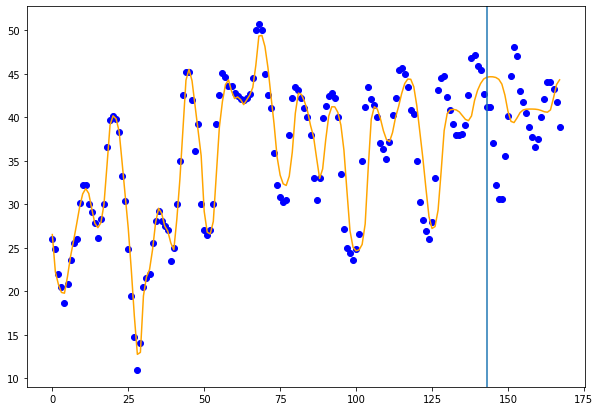

Running iteration 21 ... 
Running iteration 22 ... 
Iteration 22: 0001 | total loss -61.544464


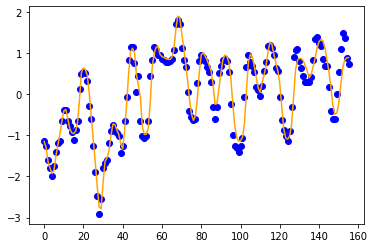

Iteration 22: 0800 | total loss -49.519359 | Time: 12.91 mins


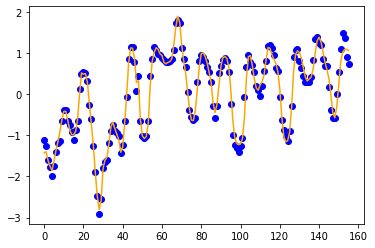

Prediction


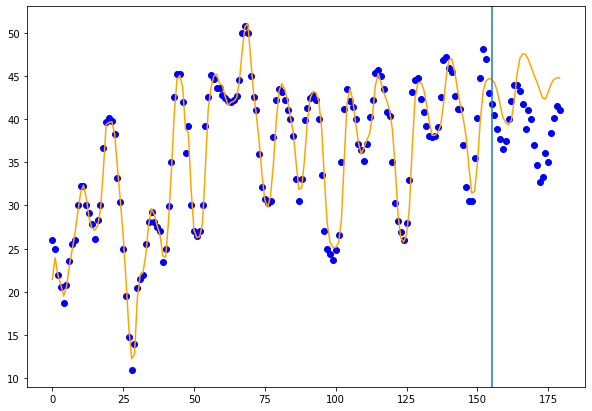

Running iteration 23 ... 
Running iteration 24 ... 
Iteration 24: 0001 | total loss -95.163628


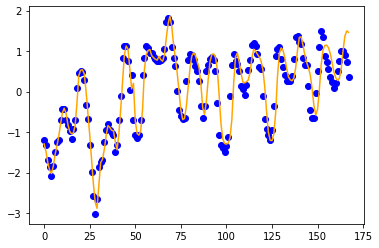

Iteration 24: 0800 | total loss -51.514743 | Time: 14.50 mins


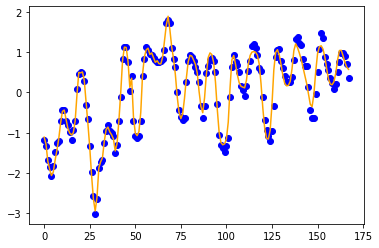

Prediction


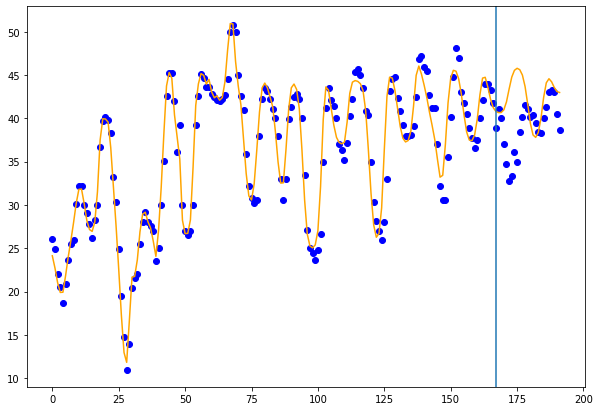

Running iteration 25 ... 
Running iteration 26 ... 
Iteration 26: 0001 | total loss -60.306225


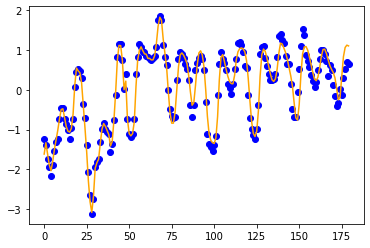

Iteration 26: 0800 | total loss -58.115262 | Time: 14.52 mins


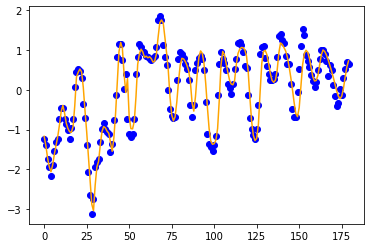

Prediction


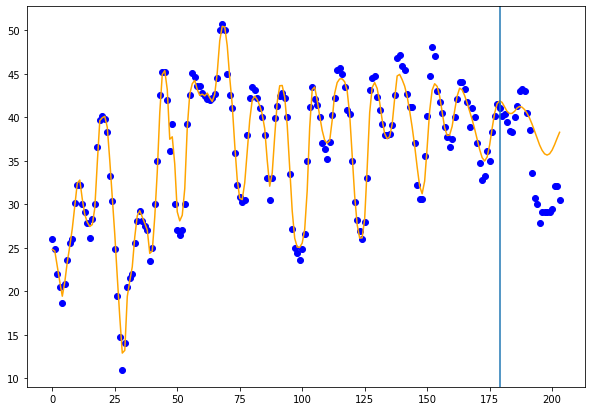

Running iteration 27 ... 
Running iteration 28 ... 
Iteration 28: 0001 | total loss -53.016434


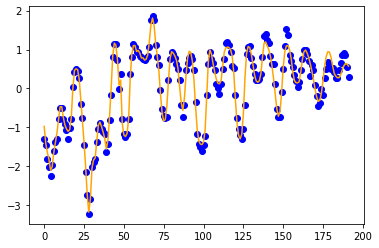

Iteration 28: 0800 | total loss -60.145951 | Time: 16.52 mins


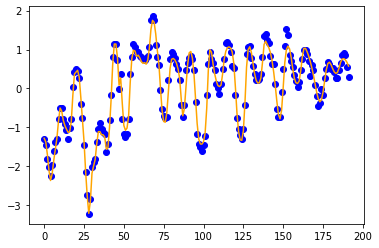

Prediction


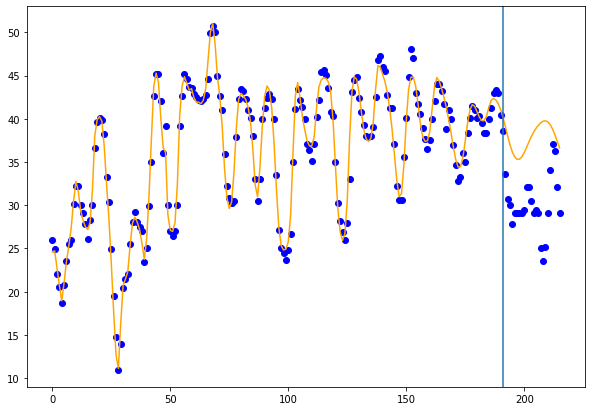

Running iteration 29 ... 
Running iteration 30 ... 
Iteration 30: 0001 | total loss -81.724770


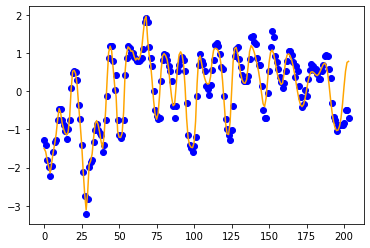

Iteration 30: 0800 | total loss -61.081820 | Time: 14.97 mins


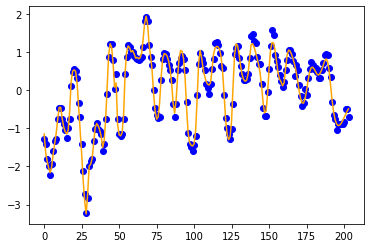

Prediction


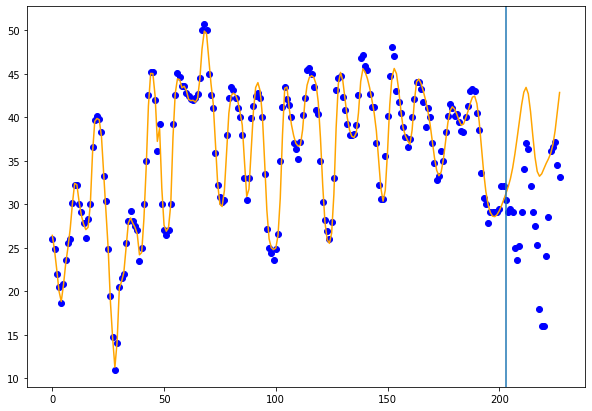

In [10]:
for j in range(31):
    print(f"Running iteration {j} ... ")
    
    trajectory_time = trajectory_time_base + time_step*j
    batch, samp_ts, mean, std = get_norm_batch(y_true=y_true, start=s, end=(s+trajectory_time))
    
    start = time.time()
    loss_meter = RunningAverageMeter()
    
    for i in range(1, epochs+1):

        optimizer.zero_grad()

        # infer q(z_0) running the RecurrentNN in reversed order
        h = rnn.init_hidden()
        for t in reversed(range(trajectory_time)):
            obs = batch[:, t, :]  # obs shape: (nbatch, obs_dim)
            # feed-forward the rnn with the obs for new t and resulting h from previous t evaluation
            out, h = rnn.forward(x=obs, h=h)

        # last out corresponds to t0, shape: (nbatch, latent_dim * 2)
        # latent space parameters are q mean and log var
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]

        # sample z0 from q distribution using reparametrization trick
        # z = mu + sigma * eps, where eps is drawn from a N(0, I)
        epsilon = torch.randn(qz0_mean.size())
        z0 = qz0_mean + epsilon * torch.exp(0.5 * qz0_logvar)

        # compute ODE in latent space for samp_ts steps and initial value z0
        # shape after permute: (nbatch, nsample, latent_dim)
        pred_z = odeint(func=latent_func, y0=z0, t=samp_ts).permute(1, 0, 2)

        # decode pred_z from latent space to observation space, pred_x shape: (nbatch, nsamples, obs_dim)
        pred_x = dec(pred_z)

        # compute loss function
        # noise_log_var shape: (nbatch, nsample, nobs)
        noise_std_ = torch.zeros(pred_x.size()) + noise_std
        noise_logvar = 2. * torch.log(noise_std_)

        # logpx, shape: (nbatch)
        logpx = log_normal_pdf(x=batch, mean=pred_x, logvar=noise_logvar).sum(-1).sum(-1)

        # p(z0) is assumed to follow N(0, I)
        pz0_mean = torch.zeros(z0.size())
        pz0_logvar = torch.zeros(z0.size())

        analytic_kl = normal_kl(mu1=qz0_mean, logvar1=qz0_logvar, mu2=pz0_mean, logvar2=pz0_logvar).sum(-1)

        # maximising ELBO is similar to minimising Kullack-Leibler(KL) divergence between Q and posterior
        # p(z|x). However, instead of using the posterior, it can be reformulated using Bayes theorem.
        # Assuming that P(z|x) (posterior) = P(x|z) (likelihood) * P(z) (prior) / P(x)
        # ELBO becomes the log-likelihood p(x|z) - KL(Q,P)| max ELBO = min (-1) ELBO
        # Resources:
        # https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
        # https://en.wikipedia.org/wiki/Evidence_lower_bound
        loss = torch.mean(-logpx + analytic_kl, dim=0)

        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
        
        if j % 2 == 0: 
            if i == 1:
                print("="*50)
                log = f"Iteration {j}: {i:04d} | total loss {-loss_meter.avg:.6f}"
                print(log)
                plot_y_y_pred(y_true=batch, y_pred=pred_x, t=samp_ts)

            #if i % 400 == 0:
            #    end = time.time()
            #    training_time = (end-start) / 60
            #    log = f"Iteration {j}: {i:04d} | total loss {-loss_meter.avg:.6f} | Time: {training_time:.2f} mins"
            #    print(log)
            #    plot_y_y_pred(y_true=batch, y_pred=pred_x, t=samp_ts)
            #    start = time.time()
                
            if i == epochs:
                
                end = time.time()
                training_time = (end-start) / 60
                log = f"Iteration {j}: {i:04d} | total loss {-loss_meter.avg:.6f} | Time: {training_time:.2f} mins"
                print(log)
                plot_y_y_pred(y_true=batch, y_pred=pred_x, t=samp_ts)
                start = time.time()
                
                print("Prediction")
                
                # test learnt dyanmic
                trajectory_time_test = trajectory_time + int(trajectory_time_base*1)
                batch_test = torch.from_numpy(np.stack([y_true[s: s+trajectory_time_test]], axis=0)).float()
                samp_ts_test = torch.arange(start=s, end=trajectory_time_test, step=1, dtype=torch.float)
                
                with torch.no_grad():
    
                    h = rnn.init_hidden()
                    for t in reversed(range(samp_ts.shape[0])):
                        obs = batch[:, t, :]
                        out, h = rnn.forward(x=obs, h=h)

                    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
                    epsilon = torch.randn(qz0_mean.size())
                    z0 = qz0_mean + epsilon * torch.exp(0.5 * qz0_logvar)

                    pred_z = odeint(func=latent_func, y0=z0, t=samp_ts_test).permute(1, 0, 2)

                    y_pred = dec(pred_z)
                
                plot_prediction_true_scale(y_true=batch_test, y_pred=y_pred, samp_ts=samp_ts_test, 
                                           t_limit=samp_ts.max().item(), mean=mean, std=std)

In [13]:
for k in range(31, 60):
    print(k)

31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [ ]:
# test learnt dyanmic
trajectory_time_test = trajectory_time + int(trajectory_time_base*4)
batch = torch.from_numpy(np.stack([y_true[s: s+trajectory_time]], axis=0)).float()
batch_test = torch.from_numpy(np.stack([y_true[s: s+trajectory_time_test]], axis=0)).float()
samp_ts = time_tensor[:trajectory_time].float()
samp_ts_test = time_tensor[:trajectory_time_test].float()

In [ ]:
with torch.no_grad():
    
    h = rnn.init_hidden()
    for t in reversed(range(samp_ts.shape[0])):
        obs = batch[:, t, :]
        out, h = rnn.forward(x=obs, h=h)
        
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size())
    z0 = qz0_mean + epsilon * torch.exp(0.5 * qz0_logvar)
    
    pred_z = odeint(func=latent_func, y0=z0, t=samp_ts_test).permute(1, 0, 2)
    
    y_pred = dec(pred_z)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(samp_ts_test, batch_test.reshape(-1), color="blue")
ax.plot(samp_ts_test, y_pred.reshape(-1), color="orange")
ax.axvline(x=samp_ts.max().item())
plt.show()